In [66]:
import sys, os.path as p; sys.path.insert(0, p.abspath('../'))

from tools.charting.plot_helpers import *
from tools.analysis.timeseries import *
from tools.analysis.data import make_forward_returns_matrix, permutate_params
from tools.analysis.tools import scols, srows, drop_duplicated_indexes
from tools.utils.utils import mstruct

from tools.loaders.binance import load_binance_data
from tqdm.notebook import tqdm
import seaborn as sns

from models.turtless_model import TurtlesGenerator, RollingHiLo, PivotsBreaks
setup_mpl_theme('dark') # run this if need to switch to light charts theme

In [52]:
def backtest(instrument, signals, ohlc):
    signals.columns = [instrument]
    return z_test_signals_inplace(shift_signals(signals, seconds=infer_series_frequency(ohlc[:10]).seconds - 1), 
                                  {instrument: ohlc}, 'crypto', spread=1, verbose=False)

In [ ]:
import ira
%alphalab dark

In [4]:
instrument = 'BTCUSDT'
data_1m = load_binance_data(instrument, '1m', path='../data')

ohlc1D = ohlc_resample(data_1m, '1D', resample_tz='UTC')
ohlc1H = ohlc_resample(data_1m, '1H')
ohlc5M = ohlc_resample(data_1m, '5Min')

# Turtles model on Rolling High/Lows

## Basic rules following model (as is from original doc)

<font color='red'><b>Strategy 1:</b></font>
20 days breakout + trade after lose only
<hr/>

In [46]:
rhi_enter = RollingHiLo(ohlc1D, 20)
rhi_exit = RollingHiLo(ohlc1D, 10)

t_classic_strategy1 = TurtlesGenerator(rhi_enter, rhi_exit, account_size=10000, dollar_per_point=1, after_lose_only=True)
s_classic_1 = t_classic_strategy1.get_signals(ohlc5M)

Interesting to see that classical rules on daily data didn't generate any signals !

In [155]:
s_classic_1

""


<font color='red'><b>Strategy 2:</b></font>
55 days breakout
<hr/>

In [49]:
rhi_enter = RollingHiLo(ohlc1D, 55)
rhi_exit = RollingHiLo(ohlc1D, 10)

t_classic_strategy2 = TurtlesGenerator(rhi_enter, rhi_exit, account_size=100000, dollar_per_point=1, after_lose_only=False)
s_classic_2 = t_classic_strategy2.get_signals(ohlc5M)

2020-10-08 21:18:12,615 - ira.simulator.SignalTester - WARNING - Positions at [2017-10-12 07:59:59] will be skipped: no prices found


Statistic,Model
Gain (USD):,195576.45
CAGR (%):,29.738
Sharpe:,1.236
Sortino:,2.335
Calmar:,1.079
MaxDD (%):,29.509
MaxDD On Init BP (%):,59.947
MaxDD (USD):,59946.870
MaxDD days:,354 days
MaxDD start:,2017-12-17

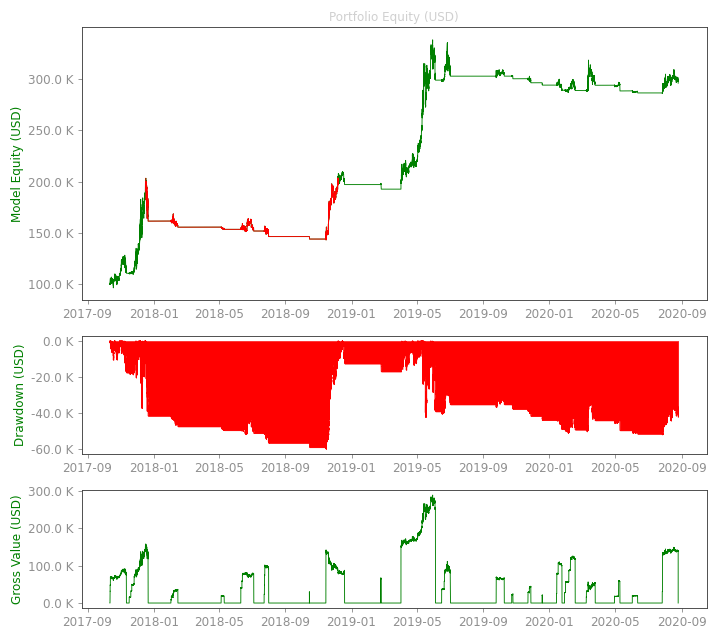

<Figure size 720x640 with 0 Axes>

In [53]:
tearsheet(backtest(instrument, s_classic_2, ohlc5M), 100000)

<hr/>
Backtest results look obvious as it catches significant trends movements but most of times it doesn't generate profit.

Also it has enough big period of drawdown - 60% drops during year
<hr/>

## Using optimal rolling window findings

Now we can try to apply our findings from rolling window research we did earlier.
As we found best parameters from [1. Running HiLo Breakout](./1.%20Running%20HiLo%20Breakout.ipynb) we will use 1H timeframe and 10 bars period for detecting breakouts.

We will use 5 minutes timeframe for trading estimation and trade on close prices.

In [56]:
rhi_enter = RollingHiLo(ohlc1H, 10)
rhi_exit = RollingHiLo(ohlc1H, 10)

### Strategy1: trade after lose only

In [59]:
t_roll_best1 = TurtlesGenerator(rhi_enter, rhi_exit, account_size=5000, dollar_per_point=1, after_lose_only=True, atr_period='1H')
s_roll_best1 = t_roll_best1.get_signals(ohlc5M)

Interesting to see positions sizes during whole period:

<BarContainer object of 1767 artists>

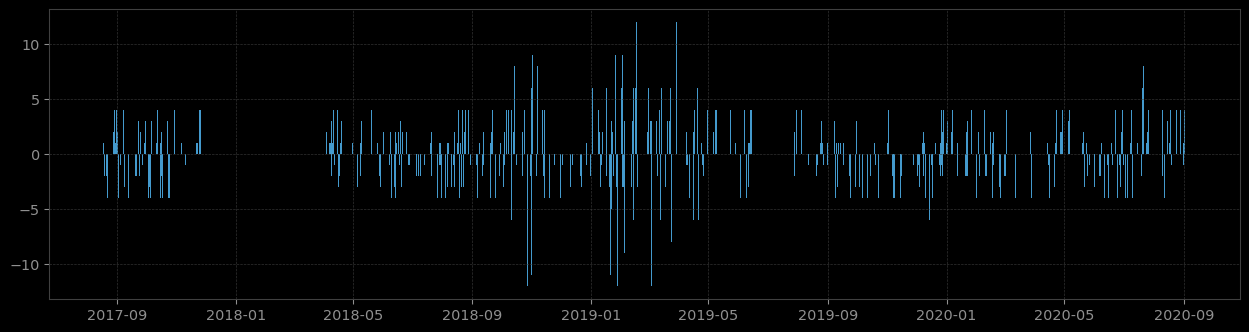

In [60]:
fig(16, 4)
plt.bar(s_roll_best1.index, s_roll_best1[0])

2020-10-08 21:26:59,536 - ira.simulator.SignalTester - WARNING - Positions at [2017-08-18 10:29:59] will be skipped: no prices found


Statistic,Model
Gain (USD):,22234.11
CAGR (%):,46.833
Sharpe:,0.871
Sortino:,2.082
Calmar:,0.934
MaxDD (%):,63.222
MaxDD On Init BP (%):,214.572
MaxDD (USD):,10728.600
MaxDD days:,355 days
MaxDD start:,2017-11-29

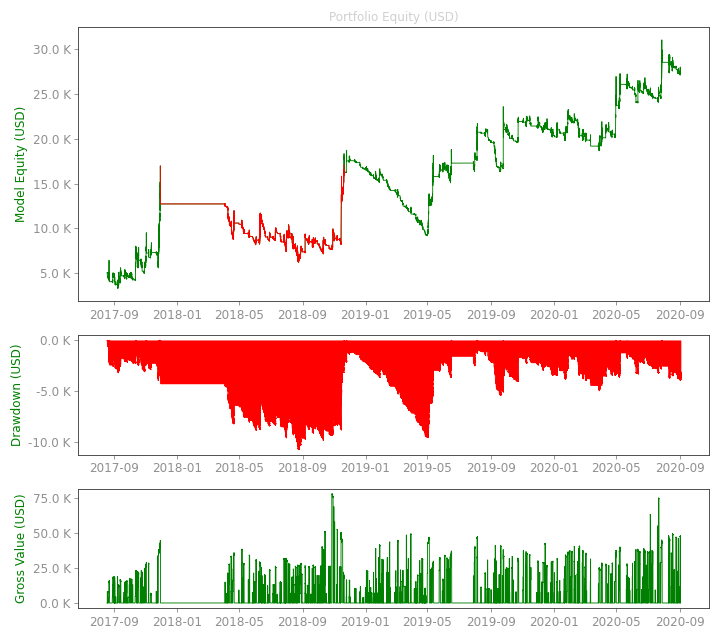

<Figure size 720x640 with 0 Axes>

In [61]:
tearsheet(backtest(instrument, s_roll_best1, ohlc5M), 5000)

<hr/>
Looks not bad but we can see many lose trades, drawdown is also big (64% during year)  
<hr/>

### Strategy2: trade after all the time

In [62]:
t_roll_best2 = TurtlesGenerator(rhi_enter, rhi_exit, account_size=5000, dollar_per_point=1, after_lose_only=False, atr_period='1H')
s_roll_best2 = t_roll_best2.get_signals(ohlc5M)

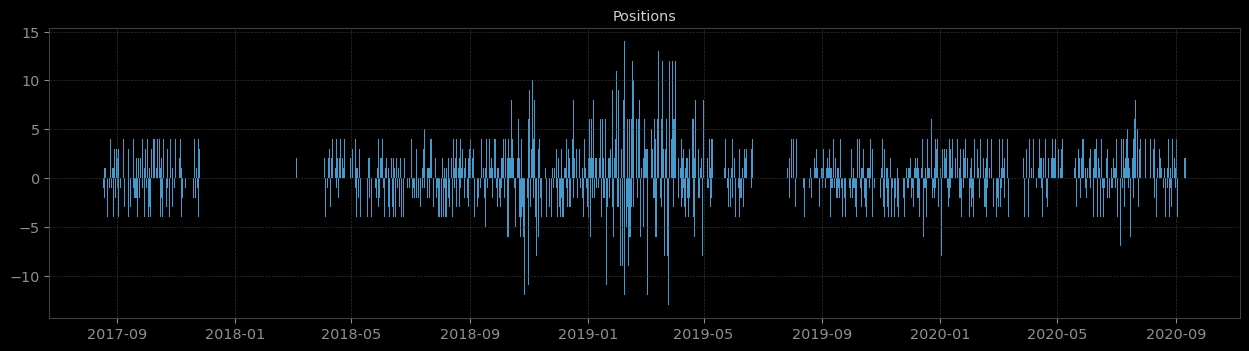

In [63]:
fig(16, 4)
plt.bar(s_roll_best2.index, s_roll_best2[0])
plt.title('Positions');

2020-10-08 21:31:25,735 - ira.simulator.SignalTester - WARNING - Positions at [2017-08-18 01:19:59] will be skipped: no prices found


Statistic,Model
Gain (USD):,56331.74
CAGR (%):,75.777
Sharpe:,1.005
Sortino:,2.202
Calmar:,1.133
MaxDD (%):,24.615
MaxDD On Init BP (%):,169.484
MaxDD (USD):,8474.180
MaxDD days:,38 days
MaxDD start:,2019-04-03

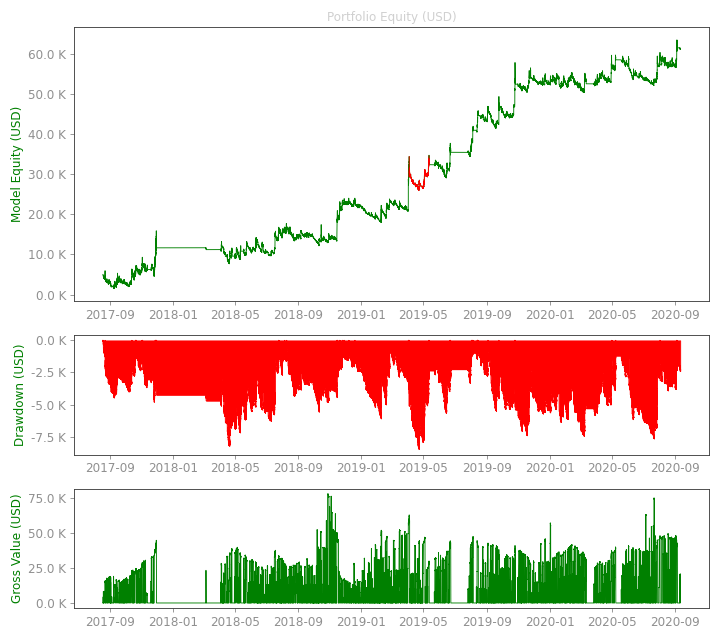

<Figure size 720x640 with 0 Axes>

In [64]:
tearsheet(backtest(instrument, s_roll_best2, ohlc5M), 5000)

<hr/>
Looks much better in sense of drawdown - 24% and only 38 days period. Also it shows highest average daily return compared to other models.
So for rolling Hi/Low breakouts this variation looks best !
<hr/>

# Turtles model on pivot points

Here we will use found parameters for best pivots parameters from this research: [2. Pivot Points Breakout](./2.%20Pivot%20Points%20Breakout.ipynb) 

Weekly pivots based on 'camarilla' calculations method.

Here we need to do bit more job to get entries/exits signals for both directions of tradings

In [151]:
def generate_pivots_sigs(instrument, ohlc, pivots_frame, meth, account_size, after_lose_only, atr_period):

    # long entries: we go long on price breaks up resistance levels
    pb_enters_lo = PivotsBreaks(ohlc,
                      ['R4', 'R3', 'R2', 'R1'],
                      [], 
                      pp_frame=pivots_frame,  method=meth)

    # and exits on price breaks down central P or supports levels
    pb_exits_lo = PivotsBreaks(ohlc,
                      [],
                      ['P', 'S1', 'S2', 'S3', 'S4'],
                      pp_frame=pivots_frame,  method=meth)

    # short entries: we go short on price breaks down support levels
    pb_enters_sh = PivotsBreaks(ohlc,
                      [], 
                      ['S1', 'S2', 'S3', 'S4'], 
                      pp_frame=pivots_frame,  method=meth)

    # and exits on price breaks up central P or resistance levels
    pb_exits_sh = PivotsBreaks(ohlc,
                      ['R4', 'R3', 'R2', 'R1', 'P'],
                      [],
                      pp_frame=pivots_frame,  method=meth)
    
    t_pvt1_lo = TurtlesGenerator(pb_enters_lo, pb_exits_lo, account_size=account_size, dollar_per_point=1, after_lose_only=after_lose_only, atr_period=atr_period)
    s_pvt1_lo = t_pvt1_lo.get_signals(ohlc)

    t_pvt1_sh = TurtlesGenerator(pb_enters_sh, pb_exits_sh, account_size=account_size, dollar_per_point=1, after_lose_only=after_lose_only, atr_period=atr_period)
    s_pvt1_sh = t_pvt1_sh.get_signals(ohlc)

    return scols(s_pvt1_lo, s_pvt1_sh).fillna(0).sum(axis=1).rename(instrument)

<hr/>
Strategy 1: open after lose only 
<hr/>

2020-10-08 22:40:09,218 - ira.simulator.SignalTester - WARNING - Positions at [2017-08-22 20:59:59] will be skipped: no prices found


Statistic,Model
Gain (USD):,71277.02
CAGR (%):,85.743
Sharpe:,1.039
Sortino:,2.572
Calmar:,1.237
MaxDD (%):,67.370
MaxDD On Init BP (%):,273.517
MaxDD (USD):,13675.830
MaxDD days:,248 days
MaxDD start:,2017-11-29

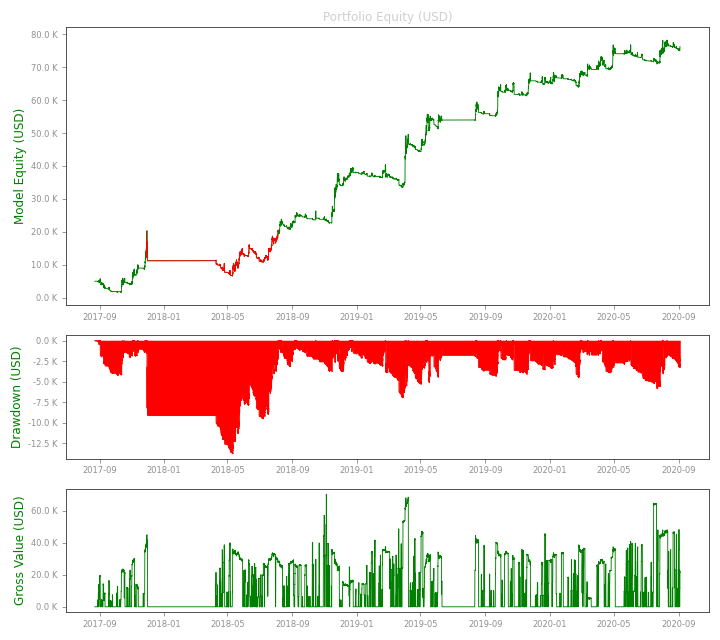

<Figure size 720x640 with 0 Axes>

In [149]:
s_pvt1 = generate_pivots_sigs(instrument, ohlc1H, 'W', 'camarilla', 5000, True, '1H')
tearsheet(backtest(instrument, s_pvt1, ohlc1H), 5000)

<hr/>
Strategy 2: open on any signal
<hr/>

2020-10-08 22:40:52,519 - ira.simulator.SignalTester - WARNING - Positions at [2017-08-21 05:59:59] will be skipped: no prices found


Statistic,Model
Gain (USD):,73989.48
CAGR (%):,87.133
Sharpe:,0.935
Sortino:,2.478
Calmar:,1.008
MaxDD (%):,21.720
MaxDD On Init BP (%):,299.520
MaxDD (USD):,14975.980
MaxDD days:,91 days
MaxDD start:,2019-06-26

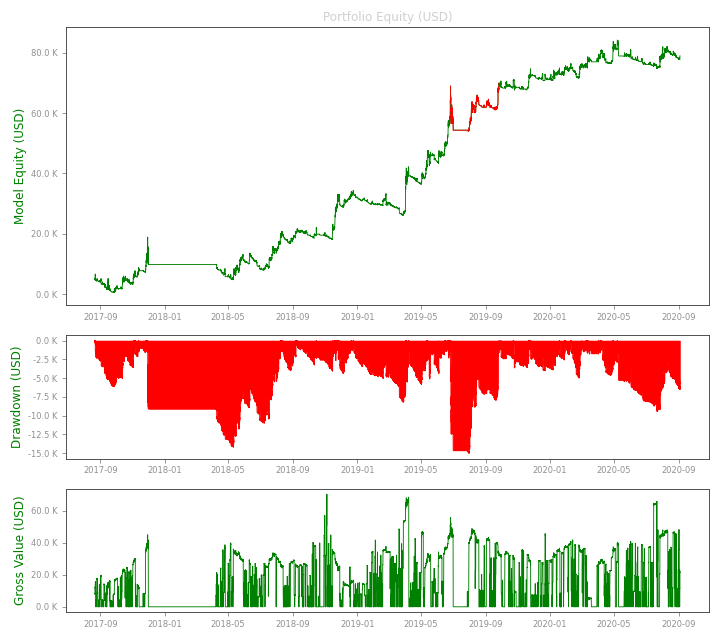

<Figure size 720x640 with 0 Axes>

In [150]:
s_pvt2 = generate_pivots_sigs(instrument, ohlc1H, 'W', 'camarilla', 5000, False, '1H')
tearsheet(backtest(instrument, s_pvt2, ohlc1H), 5000)

# Conclusions
<hr/>

It seems both models (classical rolling hi/low and pivot points) may be used for trading on crypto market using modified Turtles strategy with comparable small drawdown (21% - 24%).

There is another question about transaction costs - but it can be decreased if trade on futures/swaps assets.